# Phần 1: Khám phá dữ liệu

In [63]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from pyvis.network import Network

## 1. Import Data

In [64]:
df = pd.read_excel("./Online_Retail.xlsx")     
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])   
df['Month'] = df['InvoiceDate'].dt.month
data = df[(df['InvoiceDate'].dt.month >= 2) & (df['InvoiceDate'].dt.month <= 6) & (df['Quantity'] > 0)] # lọc tháng 2 -6, chỉ lấy các giá trị dượng ở cột Quantity
data["OrderValue"] = data["UnitPrice"] * data["Quantity"] 
display(data)

C:\Users\An\AppData\Local\Temp\ipykernel_23080\2710534815.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["OrderValue"] = data["UnitPrice"] * data["Quantity"]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,OrderValue
77628,542776,21671,RED SPOT CERAMIC DRAWER KNOB,48,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,60.00
77629,542776,21668,RED STRIPE CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,15.00
77630,542776,21670,BLUE SPOT CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,15.00
77631,542776,17013D,ORIGAMI ROSE INCENSE IN TUBE,96,2011-02-01 08:23:00,0.42,15240.0,United Kingdom,2,40.32
77632,542776,17096,ASSORTED LAQUERED INCENSE HOLDERS,48,2011-02-01 08:23:00,0.21,15240.0,United Kingdom,2,10.08
...,...,...,...,...,...,...,...,...,...,...
245898,558637,22032,BOTANICAL LILY GREETING CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245899,558637,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245900,558637,22033,BOTANICAL ROSE GREETING CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245901,558637,22029,SPACEBOY BIRTHDAY CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04


## Tìm các mặt hàng bán chạy nhất

In [65]:
num_items = data['Description'].nunique()   # đếm số lượng các mặt hàng
print(num_items)

3306


In [66]:
# tính tổng số lượng các mặt hàng đã bán
item_sales = (
    data.groupby('Description')  # nhóm theo tên hàng
      ['Quantity']             # chọn cột Quantity
      .sum()                   # tính tổng
      .sort_values(ascending=False)  # sắp xếp
)

top_items = item_sales.head(10) # lấy 10 mặt hàng bán nhiều nhất

other_total = item_sales.iloc[10:].sum() # tính tổng số lượng của các loại hàng còn lại

final_sales = pd.concat([top_items, pd.Series({'Other': other_total})]) # tạo series mới gồm top 10 và nhóm 'Other'
print(final_sales)

WORLD WAR 2 GLIDERS ASSTD DESIGNS       24716
JUMBO BAG RED RETROSPOT                 18121
ASSORTED COLOURS SILK FAN               15360
SMALL POPCORN HOLDER                    15314
PACK OF 72 RETROSPOT CAKE CASES         14491
WHITE HANGING HEART T-LIGHT HOLDER      13435
PACK OF 12 LONDON TISSUES               12501
PACK OF 60 PINK PAISLEY CAKE CASES      12342
ASSORTED COLOUR BIRD ORNAMENT           11513
VICTORIAN GLASS HANGING T-LIGHT         10527
Other                                 1618071
dtype: int64


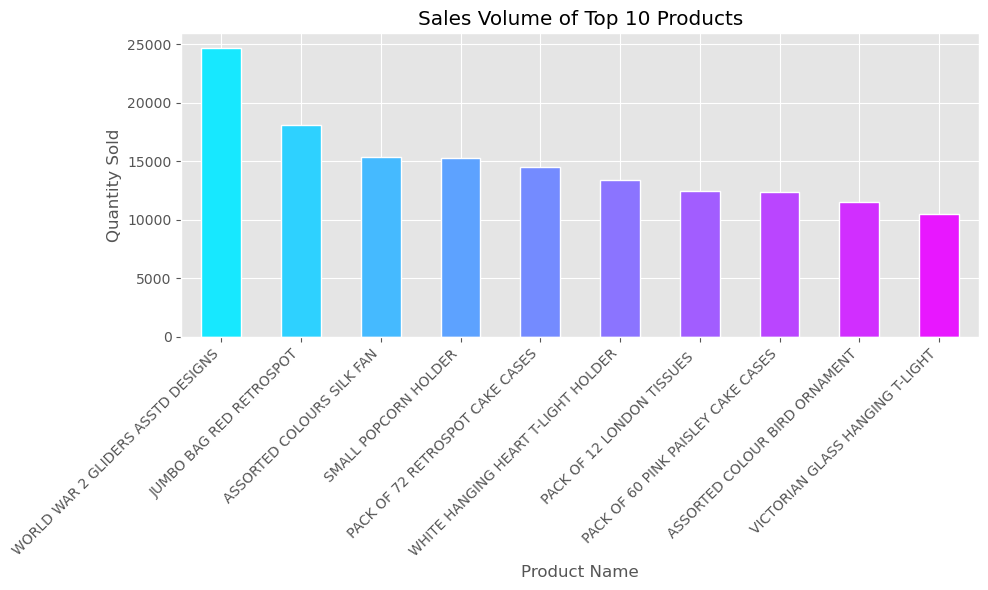

In [67]:
plt.style.use('ggplot') #chọn theme biểu đồ

colors = sns.color_palette('cool', n_colors=10) #chọn palette màu

top_items.plot(
    kind='bar',             # loại biểu đồ cột
    figsize=(10, 6),        # size 10x6 inch
    color=colors,           # chọn màu
    edgecolor='white',      # màu viện trắng
    linewidth=1
)
plt.title('Sales Volume of Top 10 Products')
plt.xlabel('Product Name')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục X cho dễ đọc, căn chỉnh nhãn theo chiều ngang về phía bên phải (ha = horizontalalignment).
plt.tight_layout()  # Điều chỉnh layout tự động
plt.show()

## 3. Tính giá trị mua hàng và tần suất mua hàng trung bình

### 3.1 Tính giá trị mua hàng trung bình

In [68]:
# gộp các mã sản phẩm (StockCode) theo đơn hàng
stockcode_joined = (
    data.groupby('InvoiceNo')['StockCode']          # nhóm theo cột InvoiceNo, sau đó truy cập cột Stockcode
    .apply(lambda x: ', '.join(x.astype(str)))      # lấy các StockCode cho về dạng chuỗi, rồi viết liền thành 1 dòng phân cách bởi dấu ","
    .reset_index(name='StockCodes')                 # trả về cột StockCode không phải dạng index
)

# gộp các mô tả sản phẩm (Description) theo đơn hàng, tương tự như đoạn trên
description_joined = (
    data.groupby('InvoiceNo')['Description']
    .apply(lambda x: ', '.join(x.astype(str)))
    .reset_index(name='Descriptions')
)

# tổng giá trị hóa đơn
invoice_total = (
    data.groupby('InvoiceNo')['OrderValue'].sum()
    .reset_index(name='TotalOrderValue')
)
# số lượng sản phẩm trong mỗi hóa đơn
item_counts = (
    data.groupby('InvoiceNo').size()
    .reset_index(name='ItemCount')
)

invoice_summary = (
    data[['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Country']]
    .drop_duplicates(subset='InvoiceNo')
)

# gộp tất cả lại
invoice_summary = (
    invoice_summary
    .merge(invoice_total, on='InvoiceNo', how='left')
    .merge(item_counts, on='InvoiceNo', how='left')
    .merge(stockcode_joined, on='InvoiceNo', how='left')
    .merge(description_joined, on='InvoiceNo', how='left')
)

# sắp xếp theo thời gian (tăng dần)
invoice_summary = (
    invoice_summary
    .sort_values(by='InvoiceDate', ascending=True)
    
)

# sửa index lại để bắt đầu từ 1
invoice_summary.index = range(1, len(invoice_summary) + 1)

# Xem kết quả
display(invoice_summary.tail(20))

,InvoiceNo,InvoiceDate,CustomerID,Country,TotalOrderValue,ItemCount,StockCodes,Descriptions
7263,558616,2011-06-30 16:22:00,16045.0,United Kingdom,269.40,16,"22960, 22993, 22961, 22907, 22469, 22171, 7145...","JAM MAKING SET WITH JARS, SET OF 4 PANTRY JELL..."
7264,558619,2011-06-30 16:28:00,14401.0,United Kingdom,316.70,14,"21382, 22287, 22286, 85194S, 23210, 23321, 233...","SET/4 SPRING FLOWER DECORATION, DECORATION WOB..."
7265,558620,2011-06-30 16:39:00,15584.0,United Kingdom,154.65,36,"21257, 21259, 21931, 22411, 85099C, 23202, 850...","VICTORIAN SEWING BOX MEDIUM, VICTORIAN SEWING ..."
7266,558621,2011-06-30 16:43:00,13745.0,United Kingdom,300.04,25,"21382, 75172, 22035, 21507, 21508, 22023, 2203...","SET/4 SPRING FLOWER DECORATION, PAINTED SEA SH..."
7267,558622,2011-06-30 16:51:00,16357.0,United Kingdom,120.05,5,"47566, 21755, 21936, 21643, 23118","PARTY BUNTING, LOVE BUILDING BLOCK WORD, RED R..."
7268,558623,2011-06-30 16:52:00,12395.0,Belgium,163.90,10,"22326, 22661, 21559, 21561, 23307, 22726, 2272...","ROUND SNACK BOXES SET OF4 WOODLAND , CHARLOTTE..."
7269,558624,2011-06-30 17:16:00,14560.0,United Kingdom,17.00,1,22624,IVORY KITCHEN SCALES
7270,558625,2011-06-30 17:29:00,14132.0,United Kingdom,301.06,18,"20761, 20762, 20765, 23191, 21224, 21221, 2203...","BLUE PAISLEY SKETCHBOOK, GREEN FERN SKETCHBOOK..."
7271,558626,2011-06-30 17:34:00,12569.0,Germany,95.28,6,"23242, 23180, 22396, 22403, 22398, POST","TREASURE TIN BUFFALO BILL , MUM'S KITCHEN CLOC..."
7272,558627,2011-06-30 17:40:00,14711.0,United Kingdom,311.86,6,"22823, 22827, 23020, 23014, 23241, 23168","CHEST NATURAL WOOD 20 DRAWERS, RUSTIC SEVENTE..."


In [69]:
print(invoice_summary['TotalOrderValue'].describe()) #bảng summary giống trong R

count     7282.000000
mean       454.731638
std       1012.693915
min          0.000000
25%        135.192500
50%        292.410000
75%        475.422500
max      38970.000000
Name: TotalOrderValue, dtype: float64


### 3.2 Tính tần suất mua hàng trung bình

In [70]:
# Đếm số lần mỗi CustomerID xuất hiện
customer_counts = (
    invoice_summary['CustomerID']
    .value_counts()
    .reset_index(name='InvoiceCount')
    .rename(columns={'index': 'CustomerID'})
)

customer_counts.index = range(1, len(customer_counts) + 1)
display(customer_counts.head(10))
print(customer_counts['InvoiceCount'].describe()) #bảng summary giống trong R

,CustomerID,InvoiceCount
1,12748.0,63
2,14911.0,59
3,17841.0,41
4,14606.0,41
5,13089.0,39
6,12971.0,34
7,15311.0,30
8,13798.0,29
9,14646.0,26
10,16029.0,24


count    2551.000000
mean        2.515092
std         3.456121
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        63.000000
Name: InvoiceCount, dtype: float64


#### Visualize CustomerID và InvoiceCount

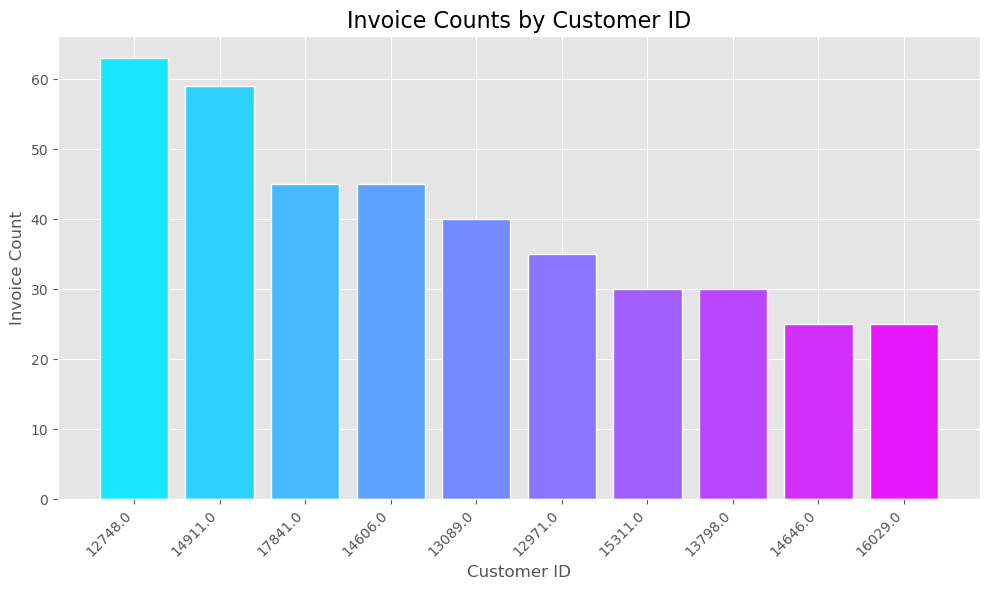

In [71]:
# Dữ liệu
data = {
    'CustomerID': [12748.0, 14911.0, 17841.0, 14606.0, 13089.0, 
                   12971.0, 15311.0, 13798.0, 14646.0, 16029.0],
    'InvoiceCount': [63, 59, 45, 45, 40, 35, 30, 30, 25, 25]
}
df = pd.DataFrame(data)

# Chọn palette 'cool'
colors = sns.color_palette('cool', len(df))

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(df['CustomerID'].astype(str), df['InvoiceCount'], color=colors, edgecolor='white', linewidth=1)


# Trang trí biểu đồ
plt.title('Invoice Counts by Customer ID', fontsize=16)
plt.xlabel('Customer ID', fontsize=12)
plt.ylabel('Invoice Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục X cho dễ đọc
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


# Phần 2: Xây dựng hệ thống gợi ý

## Load Necessary Packages

In [72]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 1. Import Dataset Filtered_Online_Retail


In [73]:
df = pd.read_csv("./Filtered_Online_Retail.csv")    # Import data Online_Retail

In [74]:
df.shape # Kiểm tra kích thước của Dataframe


(168275, 8)

In [75]:
df.head() # Hiển thị (preview) data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,542776,21671,RED SPOT CERAMIC DRAWER KNOB,48,2/1/2011 8:23,1.25,15240.0,United Kingdom
1,542776,21668,RED STRIPE CERAMIC DRAWER KNOB,12,2/1/2011 8:23,1.25,15240.0,United Kingdom
2,542776,21670,BLUE SPOT CERAMIC DRAWER KNOB,12,2/1/2011 8:23,1.25,15240.0,United Kingdom
3,542776,17013D,ORIGAMI ROSE INCENSE IN TUBE,96,2/1/2011 8:23,0.42,15240.0,United Kingdom
4,542776,17096,ASSORTED LAQUERED INCENSE HOLDERS,48,2/1/2011 8:23,0.21,15240.0,United Kingdom


In [76]:
df = df.loc[df['Quantity'] > 0] # lọc dữ liệu chỉ dữ lại hàng có Quantity > 0

# 2. Ready data for analysis

### Loại bỏ các giá trị NaNs trong Dataset

In [77]:
df['CustomerID'].describe() # thống kê mô tả về CustomerID

count    125256.000000
mean      15262.181860
std        1704.322542
min       12347.000000
25%       13869.000000
50%       15078.000000
75%       16775.000000
max       18287.000000
Name: CustomerID, dtype: float64

In [78]:
df.loc[df['CustomerID'].isna()].head() # Lọc ra những giá trị NaNs trong customerID

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
126,542783,21690,NaN,4,2/1/2011 10:02,0.00,NaN,United Kingdom
127,542784,84795C,NaN,3,2/1/2011 10:04,0.00,NaN,United Kingdom
302,542794,10135,COLOURING PENCILS BROWN TUBE,1,2/1/2011 10:56,2.46,NaN,United Kingdom
303,542794,20662,FIRST CLASS HOLIDAY PURSE,1,2/1/2011 10:56,2.46,NaN,United Kingdom
304,542794,20685,DOORMAT RED RETROSPOT,1,2/1/2011 10:56,14.13,NaN,United Kingdom


In [79]:
df = df.dropna(subset=['CustomerID']) # Loại bỏ giá trị NaNs trong CustomerID

In [80]:
df.shape # Kiểm tra lại Data sau khi đã lọc giá trị NaNs

(125256, 8)

In [81]:
df.head() # Hiển thị một vài dòng data sau khi xử lý giá trị NaNs

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,542776,21671,RED SPOT CERAMIC DRAWER KNOB,48,2/1/2011 8:23,1.25,15240.0,United Kingdom
1,542776,21668,RED STRIPE CERAMIC DRAWER KNOB,12,2/1/2011 8:23,1.25,15240.0,United Kingdom
2,542776,21670,BLUE SPOT CERAMIC DRAWER KNOB,12,2/1/2011 8:23,1.25,15240.0,United Kingdom
3,542776,17013D,ORIGAMI ROSE INCENSE IN TUBE,96,2/1/2011 8:23,0.42,15240.0,United Kingdom
4,542776,17096,ASSORTED LAQUERED INCENSE HOLDERS,48,2/1/2011 8:23,0.21,15240.0,United Kingdom


### - Customer-Item Matrix

In [82]:
# Tạo ma trận khách hàng - sản phẩm 
customer_item_matrix = df.pivot_table(
    index='CustomerID', # Mỗi hàng sẽ là một khách hàng
    columns='StockCode', # Mỗi cột sẽ là một mã sản phẩm
    values='Quantity', # Giá trị của bảng sẽ là số lượng sản phẩm Quantity
    aggfunc='sum' # Nếu khách hàng mua cùng một sản phẩm thì cộng dồn lại
)

In [83]:
customer_item_matrix.loc[12347:].head() # Lọc các dòng từ customerID từ 12347 (từ thấp lên cao) 

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214N,90214P,90214R,90214V,90214Y,BANK CHARGES,C2,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
12350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
12352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0
12353.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
customer_item_matrix.shape # Kiểm tra kích thước ma trận

(2551, 3059)

In [85]:
df['StockCode'].nunique() # Đếm số lượng stockcode trong df

3059

In [86]:
df['CustomerID'].nunique() # Đếm số lượng CustomerID

2551

In [87]:
# Chuyển đổi dữ liệu:  
# Nếu khách hàng đã mua (Quantity > 0), đặt thành 1  
# Nếu chưa mua (Quantity = 0), đặt thành 0 
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x > 0 else 0) 


C:\Users\An\AppData\Local\Temp\ipykernel_23080\3969855250.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x > 0 else 0)


In [88]:
customer_item_matrix.loc[12347:].head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214N,90214P,90214R,90214V,90214Y,BANK CHARGES,C2,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12352.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
12353.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3. Collaborative Filtering

In [89]:
from sklearn.metrics.pairwise import cosine_similarity

## 3.1 User-based Filtering

#### - User-to-User Similarity Matrix

In [90]:
# Tính toán ma trận độ tương đồng giữa khách hàng (User-User Similarity Matrix)
user_user_sim_matrix = pd.DataFrame(
    cosine_similarity(customer_item_matrix) # Sử dụng cosine_similarity
)

In [91]:
user_user_sim_matrix.head() # Hiển thị (Preview) ma trận

,0,1,2,3,4,5,6,7,8,9,...,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550
0,1.000000,0.071611,0.000000,0.031404,0.0,0.021026,0.133235,0.069886,0.143799,0.023870,...,0.0,0.095019,0.041345,0.0,0.000000,0.0,0.101274,0.0,0.014265,0.030817
1,0.071611,1.000000,0.108465,0.087706,0.0,0.000000,0.248069,0.000000,0.000000,0.066667,...,0.0,0.000000,0.115470,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.172133
2,0.000000,0.108465,1.000000,0.047565,0.0,0.000000,0.000000,0.000000,0.000000,0.108465,...,0.0,0.000000,0.000000,0.0,0.035377,0.0,0.000000,0.0,0.064820,0.000000
3,0.031404,0.087706,0.047565,1.000000,0.0,0.077254,0.054393,0.042796,0.105670,0.029235,...,0.0,0.023275,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.052414,0.075485
4,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.138675,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [92]:
# Thiết lập ma trận
user_user_sim_matrix.columns = customer_item_matrix.index # Gán tên cột là CustomerID

user_user_sim_matrix['CustomerID'] = customer_item_matrix.index
user_user_sim_matrix = user_user_sim_matrix.set_index('CustomerID')

In [93]:
user_user_sim_matrix.head() # Hiển thị 5 dòng ma trận user-user

CustomerID,12347.0,12348.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,12359.0,12360.0,...,18257.0,18260.0,18263.0,18270.0,18272.0,18273.0,18280.0,18281.0,18283.0,18287.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,1.000000,0.071611,0.000000,0.031404,0.0,0.021026,0.133235,0.069886,0.143799,0.023870,...,0.0,0.095019,0.041345,0.0,0.000000,0.0,0.101274,0.0,0.014265,0.030817
12348.0,0.071611,1.000000,0.108465,0.087706,0.0,0.000000,0.248069,0.000000,0.000000,0.066667,...,0.0,0.000000,0.115470,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.172133
12350.0,0.000000,0.108465,1.000000,0.047565,0.0,0.000000,0.000000,0.000000,0.000000,0.108465,...,0.0,0.000000,0.000000,0.0,0.035377,0.0,0.000000,0.0,0.064820,0.000000
12352.0,0.031404,0.087706,0.047565,1.000000,0.0,0.077254,0.054393,0.042796,0.105670,0.029235,...,0.0,0.023275,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.052414,0.075485
12353.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.138675,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000


#### - Xây dựng hệ thống gợi ý cho User-based

In [94]:
# Độ tương đồng của khách hàng với khách hàng khác (ví dụ với CustomerID 15240)
user_user_sim_matrix.loc[15240.0].sort_values(ascending=False)

CustomerID
15240.0    1.000000
16407.0    0.246885
15462.0    0.244949
16434.0    0.243432
14897.0    0.230940
             ...   
15673.0    0.000000
15668.0    0.000000
12790.0    0.000000
15651.0    0.000000
18287.0    0.000000
Name: 15240.0, Length: 2551, dtype: float64

In [95]:
# Giả dụ ta xét một khách hàng A với CustomerID 15240
# Danh sách các sản phẩm mà khách hàng A đã mua 
items_bought_by_A = set(customer_item_matrix.loc[15240.0]
                        [customer_item_matrix.loc[15240.0] > 0].index)

items_bought_by_A

{'16161P',
 '17013D',
 '17021',
 '17096',
 '20914',
 '21216',
 '21218',
 '21485',
 '21668',
 '21669',
 '21670',
 '21671',
 '21672',
 '21843',
 '21877',
 '22077',
 '22083',
 '22084',
 '22423',
 '22457',
 '22469',
 '22835',
 '22961',
 '23084',
 '23100',
 '23108',
 '23112',
 '23203',
 '79321',
 '85123A'}

In [96]:
# Giả xử ta xét một khách hàng B với CustomerID 17404
# Danh sách các sản phẩm mà khách hàng B đã mua
items_bought_by_B = set(customer_item_matrix.loc[17404.0]
                        [customer_item_matrix.loc[17404.0] > 0].index)
items_bought_by_B

{'15036',
 '20974',
 '20975',
 '21212',
 '21213',
 '21704',
 '21791',
 '21889',
 '21977',
 '22139',
 '22358',
 '22416',
 '22417',
 '22489',
 '22491',
 '22492',
 '22530',
 '22536',
 '22551',
 '22554',
 '22651',
 '22720',
 '22721',
 '22752',
 '22915',
 '22938',
 '22949',
 '22951',
 '22961',
 '23080',
 '23081',
 '23154',
 '23159',
 '23176',
 '23177',
 '23191',
 '23193',
 '23194',
 '84077',
 '84987',
 '84988',
 '84991',
 '85178'}

In [97]:
# Đề xuất sản phẩm cho khách hàng A 
# Tìm các sản phẩm mà khách hàng B đã mua nhưng khách hàng A chưa mua
items_to_recommend_to_A = items_bought_by_B - items_bought_by_A

In [98]:
items_to_recommend_to_A # Đề xuất sản phẩm cho khách hàng A

{'15036',
 '20974',
 '20975',
 '21212',
 '21213',
 '21704',
 '21791',
 '21889',
 '21977',
 '22139',
 '22358',
 '22416',
 '22417',
 '22489',
 '22491',
 '22492',
 '22530',
 '22536',
 '22551',
 '22554',
 '22651',
 '22720',
 '22721',
 '22752',
 '22915',
 '22938',
 '22949',
 '22951',
 '23080',
 '23081',
 '23154',
 '23159',
 '23176',
 '23177',
 '23191',
 '23193',
 '23194',
 '84077',
 '84987',
 '84988',
 '84991',
 '85178'}

In [99]:
# Tạo danh sách sản phẩm đề xuất cho khách hàng A
df.loc[ 
    df['StockCode'].isin(items_to_recommend_to_A), # lọc ra StockCode
    ['StockCode', 'Description'] # Lấy 2 cột StockCode và Description
].drop_duplicates().set_index('StockCode') # Bỏ trùng lặp và đặt StockCode làm đề mục

,Description
StockCode,
22417,PACK OF 60 SPACEBOY CAKE CASES
22139,RETROSPOT TEA SET CERAMIC 11 PC
21977,PACK OF 60 PINK PAISLEY CAKE CASES
21212,PACK OF 72 RETROSPOT CAKE CASES
22951,60 CAKE CASES DOLLY GIRL DESIGN
22358,KINGS CHOICE TEA CADDY
84988,SET OF 72 PINK HEART PAPER DOILIES
22720,SET OF 3 CAKE TINS PANTRY DESIGN
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS


## 3.2 Item-based Filtering

#### - Xây dựng hệ thống gợi ý cho Item-based

##### Tạo ma trận tương đồng sản phẩm - sản phẩm

In [100]:
# Tạo ma trận khách hàng - sản phẩm
customer_item_matrix = df.pivot_table(index="CustomerID", columns="StockCode", values="Quantity", fill_value=0)

# Tính toán độ tương tự giữa sản phẩm
item_item_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix.T), 
                                    index=customer_item_matrix.columns, 
                                    columns=customer_item_matrix.columns)

item_item_sim_matrix

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214N,90214P,90214R,90214V,90214Y,BANK CHARGES,C2,M,PADS,POST
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.0,0.004667,0.0,0.0,0.000000,0.701142,0.246778,0.000000,0.022515,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000204,0.0,0.000000
10080,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.013975,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
10120,0.004667,0.0,1.000000,0.0,0.0,0.000000,0.004081,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
10123C,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.025584,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
10124A,0.000000,0.0,0.000000,0.0,1.0,0.784465,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BANK CHARGES,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.011539,0.000000,...,0.707107,0.707107,0.707107,0.707107,0.707107,1.000000,0.000000,0.009979,0.0,0.000000
C2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.067847,0.054099,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.006846,0.0,0.010573
M,0.000204,0.0,0.000000,0.0,0.0,0.000000,0.025446,0.003256,0.004178,0.048793,...,0.014113,0.014113,0.014113,0.014113,0.014113,0.009979,0.006846,1.000000,0.0,0.008357


#### Đưa ra gợi ý

In [101]:
# Giả sử khách hàng mua sản phẩm với StockCode 22708
# Tìm ra 10 sản phẩm gần giống nhất với sản phẩm có StockCode 22708
top_10_similar_items = list(
    item_item_sim_matrix.loc["22708"] 
    .sort_values(ascending=False)
    .iloc[:10]
    .index
)

In [102]:
top_10_similar_items # Đưa ra 10 sản phẩm giống 22708

['22708',
 '22308',
 '85071C',
 '21902',
 '23176',
 '22981',
 '21899',
 '21900',
 '22615',
 '23242']

In [103]:
# Đưa ra các thông tin mô tả sản phẩm
similar_items = df.loc[
    df['StockCode'].isin(top_10_similar_items), 
    ['StockCode', 'Description']
].drop_duplicates().set_index('StockCode').loc[top_10_similar_items]

In [104]:
similar_items

,Description
StockCode,
22708,WRAP DOLLY GIRL
22308,TEA COSY BLUE STRIPE
85071C,"CHARLIE+LOLA""EXTREMELY BUSY"" SIGN"
21902,"KEY FOB , FRONT DOOR"
23176,ABC TREASURE BOOK BOX
22981,PANTRY APPLE CORER
21899,"KEY FOB , GARAGE DESIGN"
21900,"KEY FOB , SHED"
22615,PACK OF 12 CIRCUS PARADE TISSUES


In [105]:
edges = []
for item in item_item_sim_matrix.index:
    # Drop self-similarity, then take top 5 entries
    top_sim = item_item_sim_matrix.loc[item].drop(item).nlargest(5)
    for neighbor, sim in top_sim.items():
        if sim > 0:
            edges.append((item, neighbor, sim))

# e.g. only keep edges with sim ≥ 0.05
edges = [(u, v, w) for u, v, w in edges if w >= 0.75]

# Create and draw the network graph
G = nx.Graph()
G.add_nodes_from(item_item_sim_matrix.index)
for u, v, w in edges:
    G.add_edge(u, v, weight=w)

net = Network(height="750px", width="100%", notebook=True)
for n in G.nodes:
    net.add_node(n, title=n)
for u, v, d in G.edges(data=True):
    net.add_edge(u, v, value=d["weight"])
net.show("item_network.html")

# pos = nx.spring_layout(G, k=0.5, seed=42)  # fixed seed for reproducibility

# plt.figure(figsize=(10, 10))
# nx.draw_networkx_nodes(G, pos, node_size=10)
# # Scale edge widths by similarity
# edge_widths = [d['weight'] for (u, v, d) in G.edges(data=True)]
# nx.draw_networkx_edges(G, pos, width=edge_widths)

# plt.title("Item Similarity Network (Top 5 neighbors)")
# plt.axis('off')
# plt.show()

item_network.html
